# Modele generatywne; Generative Adversarial Networks 

[link](https://arxiv.org/pdf/1701.00160.pdf)

Kolejną kategorią modeli generatywnych, którą się zajmiemy są modele **Generative Adversarial Networks**. Ale zanim przejdziemy do opisu ich działania zacznijmy od omówienia różnicy między nimi, a klasycznym podejściem do generowania danych za pomocą sieci neuronowych.
        

W klasycznym ujęciu tego problemu zagadnienie generowania danych możemy sprowadzić do problemu aproksymacji estymatora największej wiarygodności (<i>Maximum Likelihood Estimation</i>, MLE) bazując na zmiennych ukrytych $z$:

$$\theta^* = \underset{\theta}{\operatorname{argmax}} \sum_{i=1}^n \log p_{model}(x_i|z_i;\theta)$$

co jest tożsame z:

$$\theta^* = \underset{\phi}{\operatorname{argmin}}d_{KL}(p_{data}(x)||p_{model}(x|z; \theta))$$

Niestety, nie jest możliwe rozwiązanie tego zadania bezpośrednio, ponieważ $p(x)$ jest nieznane, dlatego musimy przyjąć pewne założenia na temat rozkładu $q_{\phi}(x|z)$. To jest największa wadana estymacji za pomocą metod MLE; wykorzystanie rozkładu a priori $q_{\phi}(x|z)$ może wprowadać obciążenie do modelu, które zaburzy proces uczenia i obniży jakość generowanych próbek.

GANy to **modele nieparametryczne**, które nie wymagają wprowadzania dodatkowych założeń dotyczących rozkładów zmiennych losowych. Proces generatywny odbywa się nie wprost, bazując na dosyć intuicyjnym schemacie: Zamiast budować model, który uczy się odpowiednich rozkładów prawdopodobieństwa i dopoasuwuje je do danych empirycznych, uczymy dwa niezależne modele. <b>Generator</b> $\tilde{x} = G(Z;\theta)$, który generuje nowe obserwacje bazując na wektorze zmiennych ukrytych $z$ i <b>Dyskryminator</b> $D(x,\tilde{x};\psi)$, który uczy się odróżniać prawdziwe obserwacje $x$ od $\tilde{x}$ wygenerowanych przez Generator.

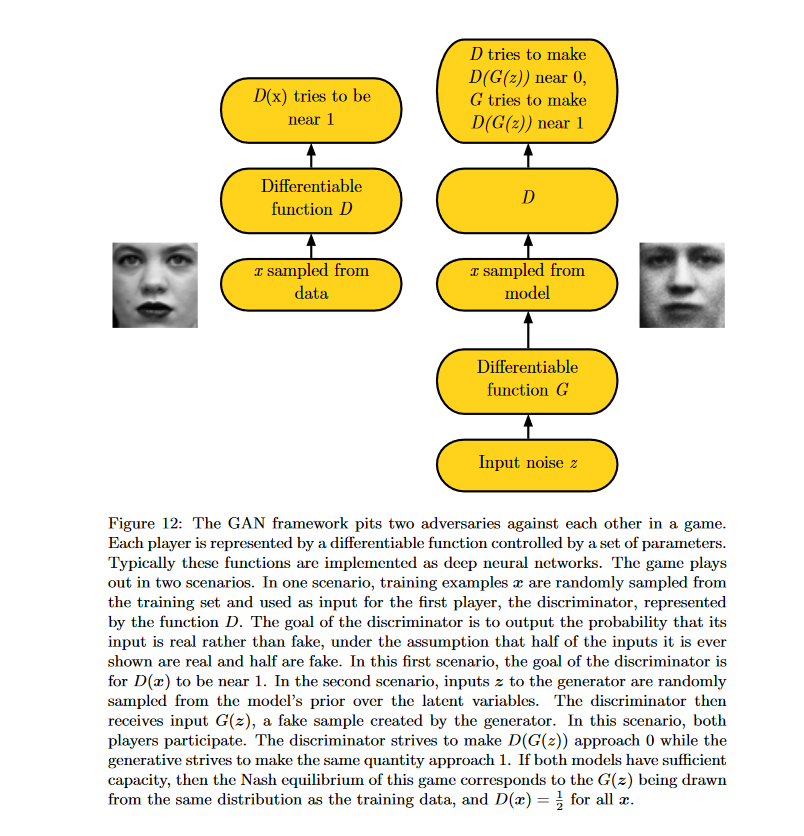

Sieci GAN mają szereg zalet w stosunku to wcześniejszych modeli generatywnych:

- Obserwacje generowane przez GANy są lepszej jakości od obserwacji generowanych przez inne modele.
- GANy wymagają mniejszej liczby założeń niż inne klasy modeli generatywnych; nie ma potrzeby przyjmowania żadnego rozkładu a priori ani modelowania procesu jako łańcuch Markowa.
- W wyniku czego, GANy są w stanie przybliżyć nietrywialne rozkłady prawdopodobieństwa bez wprowadzania obciążenia.
- GANy są architekturą semi-nadzorowaną - Dyskryminator to klasyfikator, co może być później wykorzystane do innych zadań. 

Uczenie GANów polega na jednoczesnym trenowaniu dwóch modeli, które ze sobą rywalizują. Oznacza to, że należy myśleć o tym procesie w zupełnie inny sposób niż w przypadku poprzednich modeli.

Uczenie Dyskryminatora jest intuicyjnym procesem. Celem tego modelu jest maksymalizacja prawdopodobieńtwa zaklasyfikowania rzeczywistych danych $x$ jako prawdziwe próbki, a obserwacji wygenerowanych przez Generator $\tilde{x}$ jako falsyfikaty. W rezultacie, strata Dyskryminatora to po prostu entropia krzyżowa:


$$ J_D(\theta,\psi) =- E_{x \sim p_{data}}\log D(x) -E_z \log (1 - D(G(z)) $$

Funkcja straty Generatora jest dużo mniej trywialna. Proces uczenia sieci typu GAN opiera się na siatce pojęciowej wziętej z **teorii gier**. W trakcie treningu, Dyskryminator uczy się rozróżniać prawdziwe obserwacje od falsyfikatów, natomiast celem Generatora jest oszukanie Dyskryminatora. Oznacza to, że funkcja straty Generatora jest równa:

$$J_G(\theta,\psi) = - J_D(\theta, \psi)$$

W rezultacie, proces uczenia sieci GAN możemy przedstawić jako dwuosobową **grę o sumie stałej** (*zero-sum game*), gdzie gracz (Dyskriminator lub Generator) wygrywa gdy zmaksymalizuje swoją użyteczność $U(\theta,\psi) = - J_D(\theta, \psi)$. Celem procesu uczenia jest znalezienie **równowagi Nasha** takiej gry. **Twierdzenie o Minimaxie** Johna von Neumanna mówi nam o tym, że równowagą takiej gry jest punkt siodłowy:

$$\theta^* = \operatorname{arg} \underset{\theta}{\operatorname{min}} \underset{\psi}{\operatorname{max}}U(\theta,\psi)$$

Z probabilistycznej perspektywy znalezienie równowagi takiej gry jest tożsame z minimalizacją **dywergencji Jensena-Shannona**.

Unikalna konstrukcja architektury GAN ma wiele zalet, wprowadza też pewne unikalne problemy:

- równowaga takiej gry jest punktem siodłowym; w rezultacie zadanie optymalizacyjne jest dużo trudniejsze do rozwizania niż w klasycznych modelach.
- celem jest minimalizacja entropii dyskryminatora i maksymalizacja entropii generatora. Gdy któryś z tych celi osiągniemy za szybko, model nie będzie w stanie uczyć się dalej. 
- GANs zazwyczaj nie zbiegają do rozwiązania optymalnego, tylko oscylują wokół niego. Jest to spowodowane trudnością związaną ze sterowaniem dwiema oddzielnymi funkcjami straty jednocześnie.
- **zapadanie się modelu** (*mode collapse, Helvetica scenario*) to jedna z najpowszechniejszych form braku zbieżności GANów. Jest to sytuacja w której Generator uczy się mapować różne wartości zmiennej $z$ do tego samego fragementu przestrzeni wynikowej, przez co wyniki charakteryzują się małą zmiennością.

Wspomniane problemy da się częściowo rozwiązać poprzez modyfikację funkcji straty Generatora:

- zamiast minimalizować logarytm prawdopodobieństwa, że Dyskryminator ma rację, można maksymalizować logarytm prawdopodobieństwa, że dyskryminator się myli (**non-saturating game**):
$$ J_G(\theta,\psi) =- \dfrac{1}{2}E_{z}\log D(G(z))$$
- Albo poprzez uproszczenie funkcji straty Generatora do postaci estymatora największej wiarygodności (**maximum likelihood game**): 
    $$ J_G(\theta,\psi) =- \dfrac{1}{2}E_{z}\exp (\sigma^{-1}( D(G(z))))$$


Przejdźmy do przykładu:

In [1]:
using Flux, MLDatasets
using Flux: mse, throttle, params, Statistics, onehotbatch
using Base.Iterators: partition
using Printf, BSON, JLD2, LinearAlgebra
using Zygote
using Images
using CUDA

In [2]:
use_cuda = true

true

In [3]:
 if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

[ Info: Training on GPU


In [4]:
batch_size = 128
latent_dim = 100

100

In [5]:
train_set = MNIST(:train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [6]:
Y = onehotbatch(train_set.targets, 0:9)   |> device;

In [7]:
imgs = reshape(@.(2f0 * train_set.features - 1f0), 28, 28, 1, :);

In [8]:
dataset = [(imgs[:,:,:,i], Y[:,i]) for i in partition(1:size(imgs,4), batch_size)] |> device;

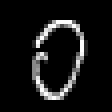

In [9]:
Gray.(dropdims((cpu(dataset[3][1][:,:,:,5]).+1.f0) ./ 2.f0; dims = 3))

In [10]:
d_labels = Chain(Dense(10,28^2), x-> reshape(x, 28, 28, 1, size(x, 2)))  |> device
d_common = Chain(Conv((3,3), 2=>128, pad=(1,1), stride=(2,2)),
                  x-> leakyrelu.(x, 0.2f0),
                  Dropout(0.4),
                  Conv((3,3), 128=>128, pad=(1,1), stride=(2,2), leakyrelu),
                  x-> leakyrelu.(x, 0.2f0),
                  x-> reshape(x, :, size(x, 4)),
                  Dropout(0.4),
                  Dense(6272, 1)) |> device

Chain(
  Conv((3, 3), 2 => 128, pad=1, stride=2),  # 2_432 parameters
  var"#5#8"(),
  Dropout(0.4),
  Conv((3, 3), 128 => 128, leakyrelu, pad=1, stride=2),  # 147_584 parameters
  var"#6#9"(),
  var"#7#10"(),
  Dropout(0.4),
  Dense(6272 => 1),                     # 6_273 parameters
)                   # Total: 6 arrays, 156_289 parameters, 1.164 KiB.

In [11]:
function discriminator(label, data)
    x = cat(d_labels(label), data, dims=3)
    return d_common(x)
end

discriminator (generic function with 1 method)

In [12]:
g_labels = Chain(Dense(10, 49), x-> reshape(x, 7 , 7 , 1 , size(x, 2))) |> device
g_latent = Chain(Dense(latent_dim, 6272), x-> leakyrelu.(x, 0.2f0), 
    x-> reshape(x, 7, 7, 128, size(x, 2))) |> device
g_common = Chain(ConvTranspose((4, 4), 129=>128; stride=2, pad=1),
            BatchNorm(128, leakyrelu),
            Dropout(0.25),
            ConvTranspose((4, 4), 128=>64; stride=2, pad=1),
            BatchNorm(64, leakyrelu),
            Conv((7, 7), 64=>1, tanh; stride=1, pad=3)) |> device

Chain(
  ConvTranspose((4, 4), 129 => 128, pad=1, stride=2),  # 264_320 parameters
  BatchNorm(128, leakyrelu),            # 256 parameters, plus 256
  Dropout(0.25),
  ConvTranspose((4, 4), 128 => 64, pad=1, stride=2),  # 131_136 parameters
  BatchNorm(64, leakyrelu),             # 128 parameters, plus 128
  Conv((7, 7), 64 => 1, tanh, pad=3),   # 3_137 parameters
)         # Total: 10 trainable arrays, 398_977 parameters,
          # plus 4 non-trainable, 384 parameters, summarysize 2.531 KiB.

In [13]:
function generator(labels, noise)
    x = cat(g_labels(labels), g_latent(noise), dims=3)
    return g_common(x)
end

generator (generic function with 1 method)

In [14]:
function discriminator_loss(real_output, fake_output)
    real_loss = Flux.Losses.logitbinarycrossentropy(real_output, 1f0)
    fake_loss = Flux.Losses.logitbinarycrossentropy(fake_output, 0f0)
    return (real_loss + fake_loss)
end

generator_loss(fake_output) = Flux.Losses.logitbinarycrossentropy(fake_output, 1f0)

generator_loss (generic function with 1 method)

In [15]:
function sample(noise, labels)
    @eval NNlib.within_gradient(generator) = false
    imgs = @.(generator(device(labels), device(noise)))
    @eval NNlib.within_gradient(generator) = true
    imgs = cpu(imgs)
    Gray.((transpose(dropdims(reduce(vcat, reduce.(hcat, partition(imgs, 4))); dims=(3, 4)))
            .+ 1f0)./2.f0)
end

sample (generic function with 1 method)

In [16]:
opt_dscr = Adam(0.0002, (0.5, 0.99))
opt_gen = Adam(0.0002, (0.5, 0.99))

Adam(0.0002, (0.5, 0.99), 1.0e-8, IdDict{Any, Any}())

In [17]:
function train_discriminator(fake_data, fake_labels, original_data, labels, opt_discr)
    ps = params(d_labels, d_common)
    loss, back = Zygote.pullback(ps) do
        discriminator_loss(discriminator(labels, original_data), discriminator(fake_labels, fake_data))
    end
    grads = back(1f0)
    Flux.Optimise.update!(opt_discr, ps, grads)
    return loss
end

Zygote.@nograd train_discriminator

[ Info: Beginning training loop...
[ Info: Epoch 1


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

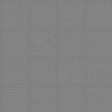

[ Info: Epoch: 1, Discriminator loss = 1.2835041, Generator loss = 0.71272856
[ Info: Epoch 2


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

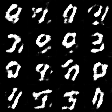

[ Info: Epoch: 2, Discriminator loss = 1.1086376, Generator loss = 1.0936525
[ Info: Epoch 3


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

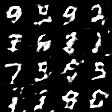

[ Info: Epoch: 3, Discriminator loss = 1.1761518, Generator loss = 0.795122
[ Info: Epoch 4


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

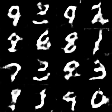

[ Info: Epoch: 4, Discriminator loss = 1.2792792, Generator loss = 0.684983
[ Info: Epoch 5


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

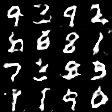

[ Info: Epoch: 5, Discriminator loss = 1.3241053, Generator loss = 0.6235192
[ Info: Epoch 6


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

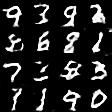

[ Info: Epoch: 6, Discriminator loss = 1.2265866, Generator loss = 0.76891947
[ Info: Epoch 7


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

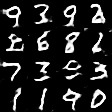

[ Info: Epoch: 7, Discriminator loss = 1.2901828, Generator loss = 0.60934865
[ Info: Epoch 8


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

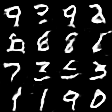

[ Info: Epoch: 8, Discriminator loss = 1.2142856, Generator loss = 0.7388864
[ Info: Epoch 9


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

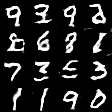

[ Info: Epoch: 9, Discriminator loss = 1.2584846, Generator loss = 0.7229458
[ Info: Epoch 10


4×4 Matrix{Int64}:
 9  8  7  1
 3  6  3  1
 9  8  5  9
 2  1  3  0

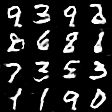

[ Info: Epoch: 10, Discriminator loss = 1.2788062, Generator loss = 0.73868215


In [18]:
noise = [randn(Float32,latent_dim, 1) for i=1:16] 
labels = [float32.(Flux.onehotbatch(rand(0:9, 1), 0:9)) for i =1:16];
@info("Beginning training loop...")
for epoch = 1:10
    d_loss,g_loss = Inf, Inf
    @info "Epoch $epoch"
    display(reduce(vcat, reduce.(hcat, partition(Flux.onecold.(labels), 4))) .- 1)
    display(sample(noise,labels))
    for (x, labels) in dataset
        latents = randn(Float32,(latent_dim, batch_size)) |> device
        y = Float32.(Flux.onehotbatch(rand(0:9, batch_size), 0:9)) |> device
        ps = params(g_labels, g_latent, g_common)
        g_loss, back = Zygote.pullback(ps) do
            fake = generator(y, latents)
            d_loss = train_discriminator(fake, y, x, labels, opt_dscr)
            generator_loss(discriminator(y, fake))
        end
        grads = back(1f0)
        Flux.Optimise.update!(opt_gen, ps, grads)
    end
    @info("Epoch: $epoch, Discriminator loss = $d_loss, Generator loss = $g_loss")
    model_params = cpu(Flux.state((d_labels, d_common, g_labels, g_latent, g_common)))
    BSON.@save "CDGAN_MNIST.bson" model_params 
    jldsave("CDGAN_MNIST.jld2"; d_labels = cpu(Flux.state(d_labels)), d_common = cpu(Flux.state(d_common)), 
            g_labels = cpu(Flux.state(g_labels)), g_latent = cpu(Flux.state(g_latent)),  g_common = cpu(Flux.state(g_common)))
end

In [19]:
d_labels = Chain(Dense(10,28^2), x-> reshape(x, 28, 28, 1, size(x, 2)))  |> device
d_common = Chain(Conv((3,3), 2=>128, pad=(1,1), stride=(2,2)),
                  x-> leakyrelu.(x, 0.2f0),
                  Dropout(0.4),
                  Conv((3,3), 128=>128, pad=(1,1), stride=(2,2), leakyrelu),
                  x-> leakyrelu.(x, 0.2f0),
                  x-> reshape(x, :, size(x, 4)),
                  Dropout(0.4),
                  Dense(6272, 1)) |> device

g_labels = Chain(Dense(10, 49), x-> reshape(x, 7 , 7 , 1 , size(x, 2))) |> device
g_latent = Chain(Dense(latent_dim, 6272), x-> leakyrelu.(x, 0.2f0), 
    x-> reshape(x, 7, 7, 128, size(x, 2))) |> device
g_common = Chain(ConvTranspose((4, 4), 129=>128; stride=2, pad=1),
            BatchNorm(128, leakyrelu),
            Dropout(0.25),
            ConvTranspose((4, 4), 128=>64; stride=2, pad=1),
            BatchNorm(64, leakyrelu),
            Conv((7, 7), 64=>1, tanh; stride=1, pad=3)) |> device

model_params = JLD2.load("CDGAN_MNIST.jld2")


Flux.loadmodel!(d_labels, device(model_params["d_labels"]))
Flux.loadmodel!(d_common, device(model_params["d_common"]))
Flux.loadmodel!(g_labels, device(model_params["g_labels"]))
Flux.loadmodel!(g_latent, device(model_params["g_latent"]))
Flux.loadmodel!(g_common, device(model_params["g_common"]))

Chain(
  ConvTranspose((4, 4), 129 => 128, pad=1, stride=2),  # 264_320 parameters
  BatchNorm(128, leakyrelu),            # 256 parameters, plus 256
  Dropout(0.25),
  ConvTranspose((4, 4), 128 => 64, pad=1, stride=2),  # 131_136 parameters
  BatchNorm(64, leakyrelu),             # 128 parameters, plus 128
  Conv((7, 7), 64 => 1, tanh, pad=3),   # 3_137 parameters
)         # Total: 10 trainable arrays, 398_977 parameters,
          # plus 4 non-trainable, 384 parameters, summarysize 2.531 KiB.

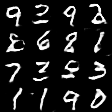

In [20]:
display(sample(noise,labels))

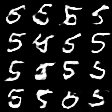

In [21]:
noise = [randn(Float32,latent_dim, 1) for i=1:16]
labels = [float32.(Flux.onehotbatch(5, 0:9)) for i =1:16];
display(sample(noise,labels))

## Dodatkowa praca domowa

1. Zmodyfikuj funkcję straty Generatora pokazanego na zajęciach. Zaimplementuj ją jako estymator największej wiarygodności (maximum likelihood game). Jak taka zmiana wpływa na wyniki? <b>(8 punktów)</b>

